## 1. Load Modules

In [1]:
import matplotlib.pyplot as plt
import cmath
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import sem
from sklearn.manifold import TSNE
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mutual_info_score
import pickle
import pandas as pd
import seaborn as sns
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.ticker import StrMethodFormatter
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import pandas as pd
import os
from helper import *
#from ipynb.fs.full.helper import *

## 2. Calculating Text Diversity from topic representation

In [2]:
topics_to_keep = 5
topic_representation = pickle.load(open('../Data/topic_representation.pkl','rb'))
text_div_dic = create_div(topic_representation,topics_to_keep)
# plt.hist(text_div_dic.values(),bins=100)
pickle.dump(text_div_dic,open('../Data/text_div_dic.pkl','wb'))

## 3. Create Dataframe with Diversity Information

### 3a. Load Full Data and Normalize Rating 

In [3]:
with open('../Data/all_features.pkl','rb') as f:
    all_df = pickle.load(f)

rating_names = ['fascinating', 'ingenious', 'jaw-dropping', 'longwinded', 'unconvincing','ok']
norm_df = pd.DataFrame({})
tot_count = all_df['total_count'].to_numpy()
for key in all_df:
    if key not in rating_names:
        norm_df[key] = all_df[key]
    else:
        rat = all_df[key].to_numpy()
        rat = rat/tot_count
        norm_df[key] = rat
all_df.head() 
all_df.keys()

Index(['Video_ID', 'totalviews', 'total_count', 'beautiful', 'confusing',
       'courageous', 'fascinating', 'funny', 'informative', 'ingenious',
       'inspiring', 'jaw-dropping', 'longwinded', 'obnoxious', 'ok',
       'persuasive', 'unconvincing', 'doc_rep', 'Male', 'Female', 'Both',
       'Other', 'White', 'Black_or_African_American',
       'American_Indian_or_Alaska_Native', 'Asian',
       'Native_Hawaiian_or_Other_Pacific_Islander', 'Latino_or_Hispanic',
       'Other_or_mixed race'],
      dtype='object')

### 3b. Add Text Diversity

In [4]:
text_div = []
for vid in all_df['Video_ID']:
    text_div.append(text_div_dic[vid])
    
norm_df["Text Diversity"] = text_div

### 3c. Add Gesture Diversity

In [5]:
visual_variation=pickle.load(open("../Data/tid_vs_variation_visual.pkl","rb"))
vid_div = []
for vid in all_df['Video_ID']:
    if vid in visual_variation:
        vid_div.append(visual_variation[vid])
    else:
        vid_div.append(np.nan)
norm_df["Gesture Diversity"] = vid_div

### 3d. Remove Outlier w.r.t. Text Diversity and Rating

In [6]:
df = pd.DataFrame(norm_df)     
print("Shape before removing outlier: ",df.shape)

#Removing outlier w.r.t. Gesture Diversity
df = df.dropna()
q = df["Gesture Diversity"].quantile(0.99)
df = df[df["Gesture Diversity"] < q]

#Removing outlier w.r.t. Ratings
for rat in rating_names:
    q = df[rat].quantile(0.99)
    df = df[df[rat] < q]

#Removing outlier w.r.t. Text Diversity
q = df["Text Diversity"].quantile(0.99)
df = df[df["Text Diversity"] < q]
df.head()
print("Shape after removing outlier: ",df.shape)

#Scaling
things_to_scale = rating_names+["Text Diversity","Gesture Diversity"]
min_max_scaler = MinMaxScaler()
print("Text Diversity min and max before scaling",min(df["Text Diversity"]),max(df["Text Diversity"]))
df[things_to_scale] = min_max_scaler.fit_transform(df[things_to_scale])
print("Text Diversity min and max after scaling",min(df["Text Diversity"]),max(df["Text Diversity"]))

Shape before removing outlier:  (2383, 31)
Shape after removing outlier:  (2151, 31)
Text Diversity min and max before scaling 0.02142131007726288 1.4051554027436888
Text Diversity min and max after scaling 0.0 1.0


### 3e. Binarize Ratings

In [7]:
for rat in rating_names:
    bin_rat = "bin_"+rat
    med = df[rat].median()
    df[bin_rat] = (df[rat] >= med).astype(int)
    
df.head()

,Video_ID,totalviews,total_count,beautiful,confusing,courageous,fascinating,funny,informative,ingenious,...,Latino_or_Hispanic,Other_or_mixed race,Text Diversity,Gesture Diversity,bin_fascinating,bin_ingenious,bin_jaw-dropping,bin_longwinded,bin_unconvincing,bin_ok
0,1,3208733,2948,58,62,140,0.114778,545,445,0.063530,...,0,0,0.219479,0.391075,0,0,1,1,1,1
2,1000,614058,1413,26,29,16,0.849902,39,260,0.599939,...,0,0,0.273917,0.403558,1,1,1,1,0,0
3,1002,949193,1934,84,8,198,0.195927,6,186,0.392451,...,0,0,0.167392,0.652438,0,1,0,1,0,0
5,1004,1359837,4988,176,13,1248,0.054670,1,902,0.031619,...,0,0,0.297525,0.773434,0,0,1,0,0,0
6,1005,589982,956,5,14,120,0.087948,0,176,0.106545,...,0,0,0.076846,0.582714,0,0,1,1,1,1


### 3f. Categorize Diversity

In [8]:
num_cat_div = 5
df["TD_cat"] = pd.cut(df["Text Diversity"],num_cat_div,labels=False)
df["GD_cat"] = pd.cut(df["Gesture Diversity"],num_cat_div,labels=False)

## 4. Create seperate dataframe for different race and gender

### 4a. Create seperate dataframe for male and female

In [9]:
male_df = df[df["Female"]==1]
female_df = df[df["Female"]==0]
print("Number of male speakers: ",male_df.shape[0])
print("Number of female speakers: ",female_df.shape[0])

Number of male speakers:  1417
Number of female speakers:  734


### 4b. Create seperate dataframe for white and non-white

In [10]:
white_df = df[df["White"]==1]
nonwhite_df = df[df["White"]==0]
print("Number of white speakers: ",white_df.shape[0])
print("Number of non-white speakers: ",nonwhite_df.shape[0])

Number of white speakers:  1704
Number of non-white speakers:  447


### 4c. Rating vs Sensitive Attributes

In [11]:
dic ={}
m,f,w,nw = [],[],[],[]
for rat in rating_names:
    bin_rat = "bin_"+rat
    m.append(male_df[male_df[bin_rat]==1].shape[0]/float(male_df.shape[0]))
    f.append(female_df[female_df[bin_rat]==1].shape[0]/float(female_df.shape[0]))
    w.append(white_df[white_df[bin_rat]==1].shape[0]/float(white_df.shape[0]))
    nw.append(nonwhite_df[nonwhite_df[bin_rat]==1].shape[0]/float(nonwhite_df.shape[0]))
    
dic["Male"] = m
dic["Female"] = f
dic["White"] = w
dic["Nonwhite"] = nw

rating_df = pd.DataFrame(dic,index=rating_names)
rating_df.head()

,Male,Female,White,Nonwhite
fascinating,0.563162,0.378747,0.531690,0.380313
ingenious,0.582216,0.341962,0.517019,0.436242
jaw-dropping,0.541990,0.419619,0.509390,0.465324
longwinded,0.501764,0.497275,0.525235,0.404922
unconvincing,0.494707,0.510899,0.522887,0.413870


### 4d. Diversity array and Rating Dictionary

In [12]:
text_all_diversity_ar = df["Text Diversity"].to_numpy()
vid_all_diversity_ar = df["Gesture Diversity"].to_numpy()
text_all_rat_dic = {}
for rat in rating_names:
    text_all_rat_dic[rat] = df[rat].to_numpy()
    
text_male_diversity_ar = male_df["Text Diversity"].to_numpy()
text_female_diversity_ar = female_df["Text Diversity"].to_numpy()
vid_male_diversity_ar = male_df["Gesture Diversity"].to_numpy()
vid_female_diversity_ar = female_df["Gesture Diversity"].to_numpy()
text_male_rat_dic = {}
text_female_rat_dic = {}
for rat in rating_names:
    text_male_rat_dic[rat] = male_df[rat].to_numpy()
    text_female_rat_dic[rat] = female_df[rat].to_numpy()

## 5. Required Plots for the papers

### 5a. Plot Figure 3

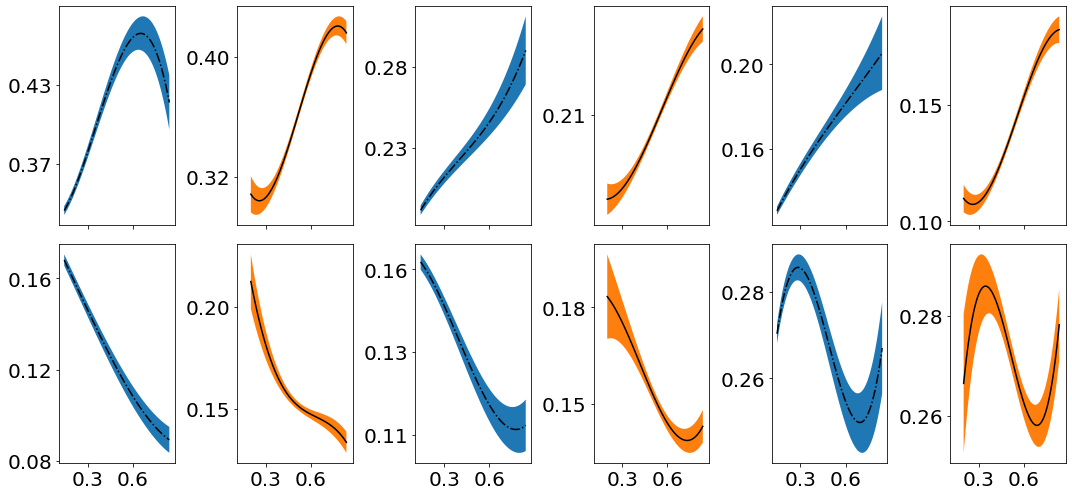

In [13]:
num_bin, epsilon = 5, 0.5
f, ax = plt.subplots(2,6,figsize=(15,7),sharex=True)
rating_names = ['fascinating', 'ingenious', 'jaw-dropping', 'longwinded', 'unconvincing','ok']
for i,rat_name in enumerate(rating_names):
    
    text_div_ar,text_rat_dic,visual_div_ar,visual_rat_dic,rat_name,num_bin_text,num_bin_vid = text_all_diversity_ar,text_all_rat_dic,vid_all_diversity_ar, text_all_rat_dic,rat_name,num_bin,num_bin
    
    
    text_mean_divs, text_mean_rates, text_std_divs, text_std_rates = do_binning(text_div_ar,text_rat_dic[rat_name],num_bin_text)
    visual_mean_divs, visual_mean_rates, visual_std_divs, visual_std_rates = do_binning(visual_div_ar,visual_rat_dic[rat_name],num_bin_vid)


    #interpolation
    tf_mean = interp1d(text_mean_divs, text_mean_rates,kind='cubic')
    tf_std = interp1d(text_mean_divs, text_std_rates,kind='cubic')

    vf_mean = interp1d(visual_mean_divs, visual_mean_rates,kind='cubic')
    vf_std = interp1d(visual_mean_divs, visual_std_rates,kind='cubic')

    
    ax1,ax2 = ax[i//3][(2*i)%6], ax[i//3][(2*i)%6+1]
    
    x_axis = np.linspace(min(text_mean_divs),max(text_mean_divs),100)
    ax1.plot(x_axis, tf_mean(x_axis),'-.',label='Text Mean',color='k')
    error = epsilon*tf_std(x_axis)
    ax1.fill_between(x_axis, tf_mean(x_axis)-error,tf_mean(x_axis)+error,facecolor='#1f77b4')
    l1 = ax1.get_yticks()
    gap1 = (l1[-1]-l1[0])/3.0#float(str((l1[-1]-l1[0])/3.0)[:4])
    
    ax1.yaxis.set_major_locator(MultipleLocator(gap1))
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    if i<3:
        ax1.set_xticks([])
    ax1.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    
    
    x_axis = np.linspace(min(visual_mean_divs),max(visual_mean_divs),100)
    ax2.plot(x_axis, vf_mean(x_axis),'-',label='Visual Mean',color='k')
    error = epsilon*vf_std(x_axis)
    l2 = ax2.get_yticks()
    gap2 = (l2[-1]-l2[0])/2.0
    ax2.yaxis.set_major_locator(MultipleLocator(gap2))
    ax2.fill_between(x_axis, vf_mean(x_axis)-error,vf_mean(x_axis)+error,facecolor='#ff7f0e')
    for tick in ax2.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    if i<3:
        ax2.set_xticks([])
    ax1.xaxis.set_major_locator(MultipleLocator(0.3))
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    ax2.xaxis.set_major_locator(MultipleLocator(0.3))
    for tick in ax2.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
    plt.subplots_adjust(wspace = 0.5)
    
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))    

    #plt.legend()
plt.tight_layout()
plt.savefig('../Plots/Figure3.pdf')

### 5b. Plot Figure 4

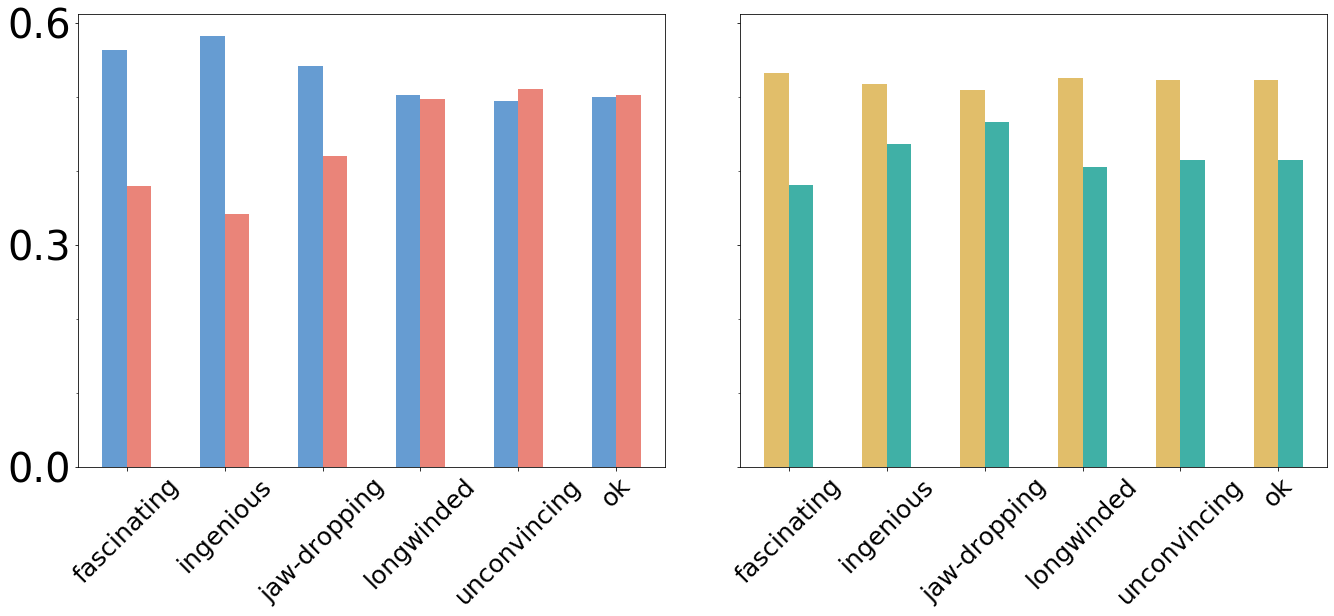

In [14]:
fig, axes = plt.subplots(1, 2,figsize=(20,10),sharey=True)

rating_df.loc[rating_names][["Male","Female"]].plot.bar(ax=axes[0],rot=45,fontsize=15,color=['#669cd2','#ea8479'],legend=False)
axes[0].set_xticklabels(rating_names)

axes[0].yaxis.set_major_locator(MultipleLocator(0.3))
for tick in axes[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(40) 
for tick in axes[0].xaxis.get_major_ticks():
    tick.label.set_fontsize(25) 


rating_df.loc[rating_names][["White","Nonwhite"]].plot.bar(ax=axes[1],rot=45,fontsize=15,color=['#E1BE6A','#40B0A6'],legend=False)
axes[1].set_xticklabels(rating_names)

for tick in axes[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(25) 

plt.tight_layout(pad = 6.0)
plt.savefig('../Plots/Figure4.pdf')


### 5c. Plot Figure 5

0
1
2
3


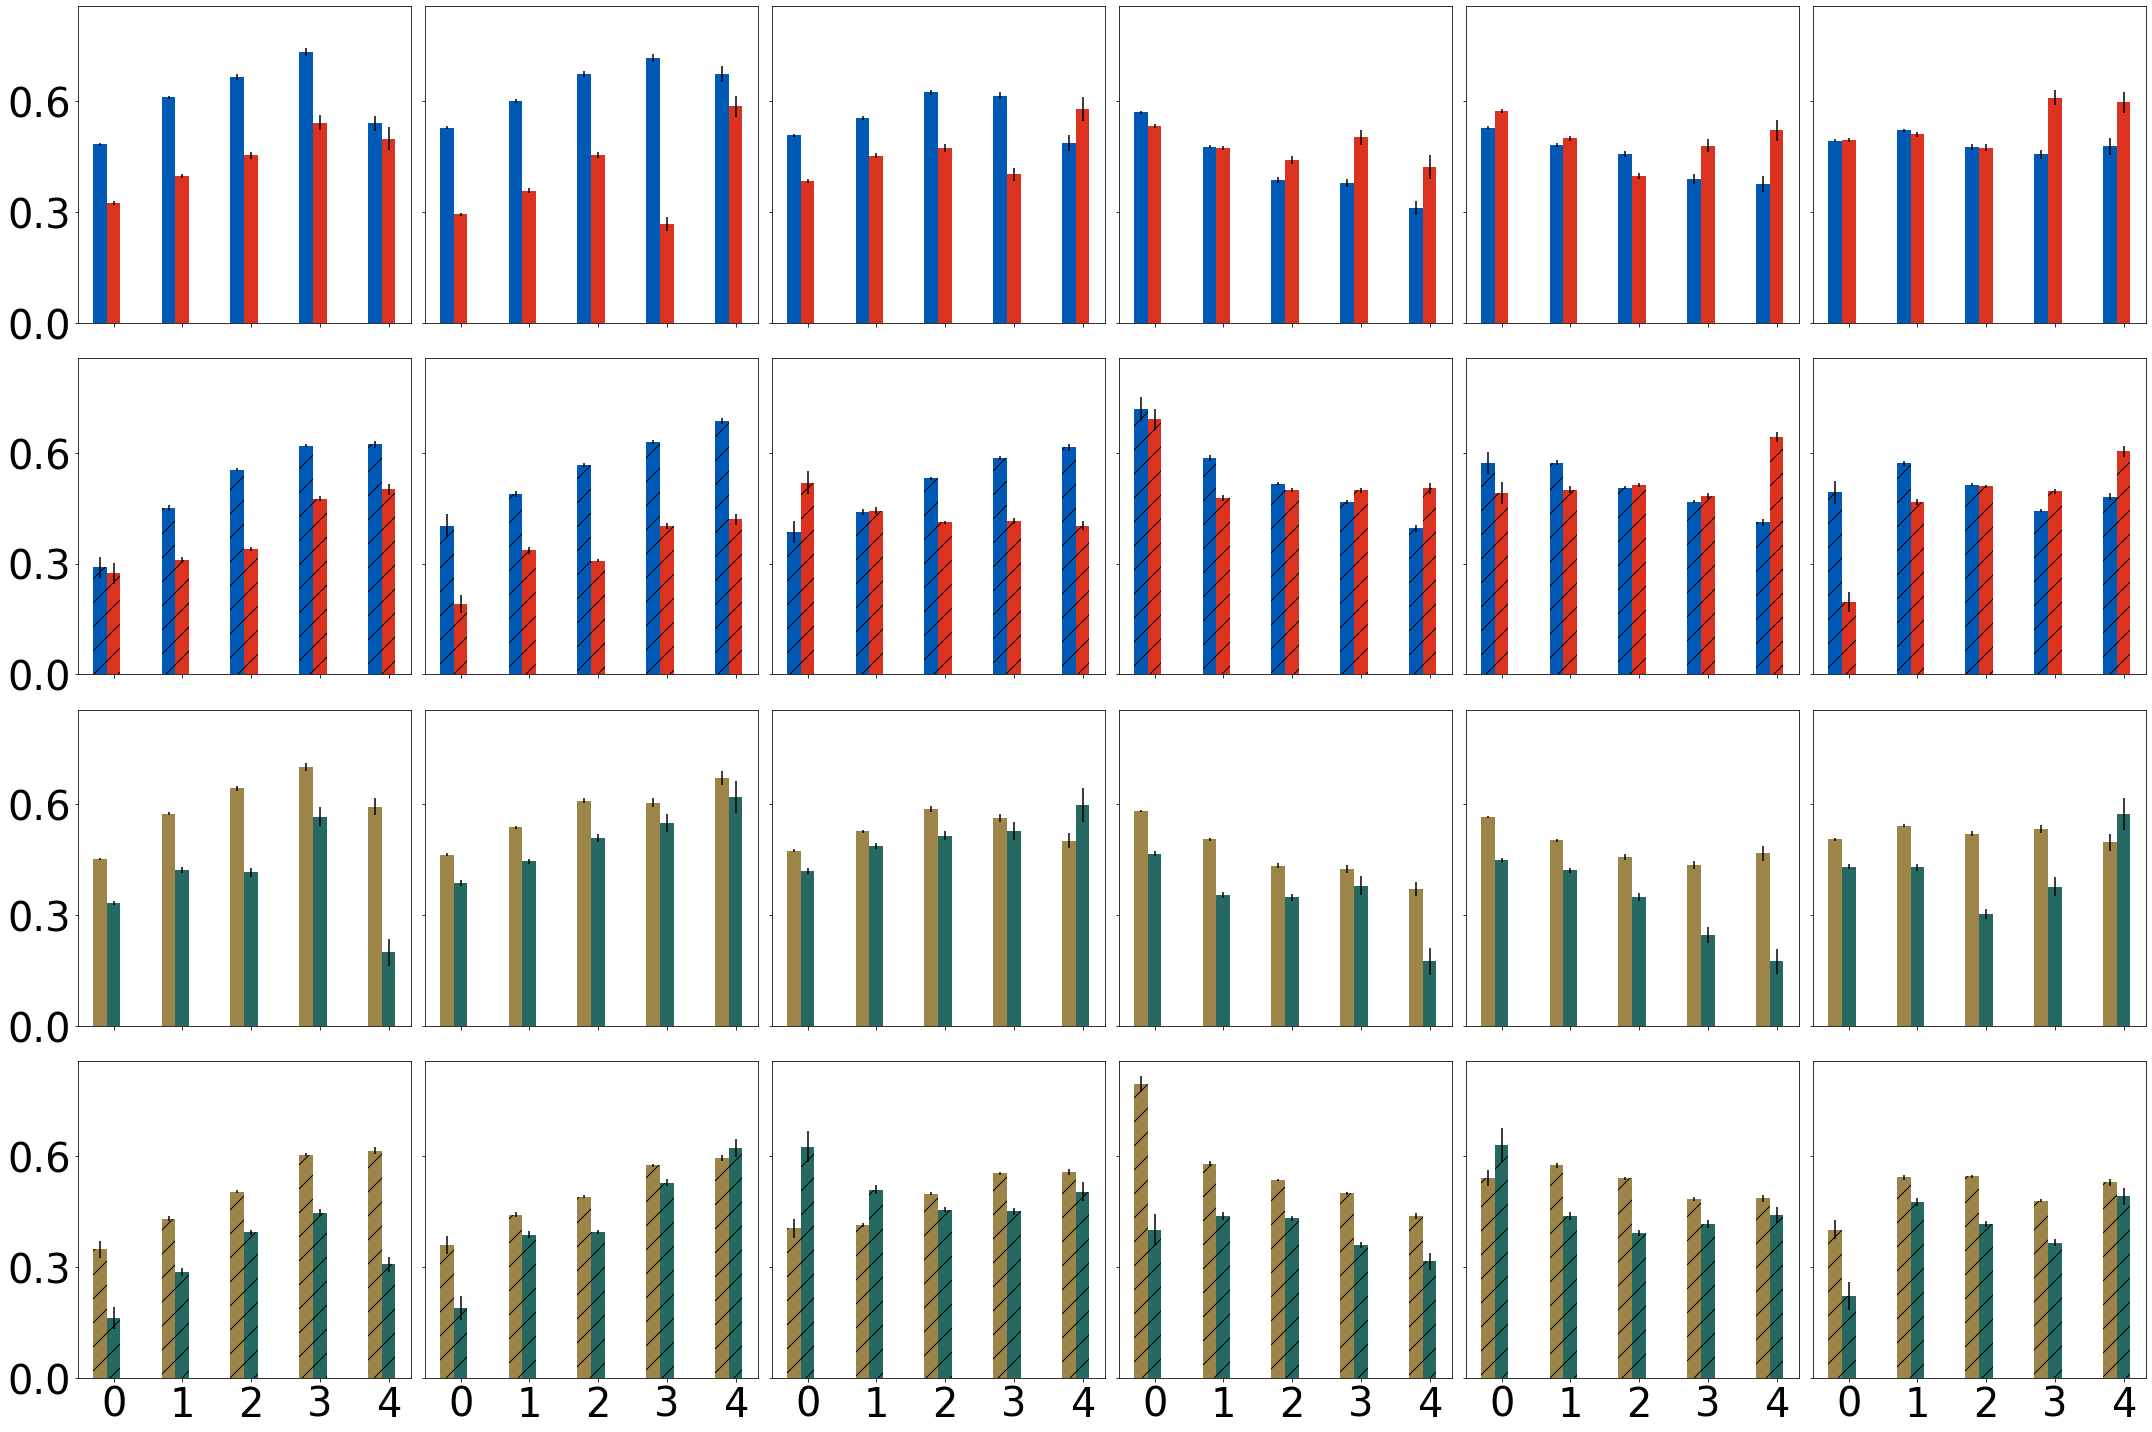

In [15]:
nrow, ncol = 4, len(rating_names)
fig,axs = plt.subplots(nrow,ncol,figsize=(30,20),sharex=True,sharey=True)
for row_ind in range(nrow):
    print(row_ind)
    for col_ind, rat in enumerate(rating_names):
        if row_ind == 0:
            group1_df, group2_df, div_type = male_df, female_df, 'TD_cat'
            color1, color2 = '#005AB5', '#DC3220'
        elif row_ind == 2:
            group1_df, group2_df, div_type = white_df, nonwhite_df,'TD_cat'
            color1, color2 = '#9D854A', '#266963'
        elif row_ind == 1:
            group1_df, group2_df, div_type = male_df, female_df, 'GD_cat'
            color1, color2 = '#005AB5', '#DC3220'
        else:
            group1_df, group2_df, div_type = white_df, nonwhite_df,'GD_cat'
            color1, color2 = '#9D854A', '#266963'
    

        mean_rate_g1, std_rate_g1, mean_rate_g2, std_rate_g2 = generate_errorbardata(group1_df, group2_df,rat,div_type)
        
        
        x = np.array(range(num_cat_div))
        ax = axs[row_ind][col_ind]
        
        if row_ind%2 == 1:
            ax.bar(x-0.2, mean_rate_g1, width=0.2, color=color1, yerr = 2*np.array(std_rate_g1),label="white",hatch=("/"))
            ax.bar(x, mean_rate_g2, width=0.2, color=color2, yerr = 2*np.array(std_rate_g2),label="nonwhite",hatch=("/"))
        else:
            ax.bar(x-0.2, mean_rate_g1, width=0.2, color=color1, yerr = 2*np.array(std_rate_g1),label="white")
            ax.bar(x, mean_rate_g2, width=0.2, color=color2, yerr = 2*np.array(std_rate_g2),label="nonwhite")
        
        #ax.set_ylim(0.2,0.8)
        ax.yaxis.set_major_locator(MultipleLocator(0.3))
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(40)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(40) 
plt.tight_layout()
plt.savefig('../Plots/Figure5.pdf')

### 5d. Plot Figure 7

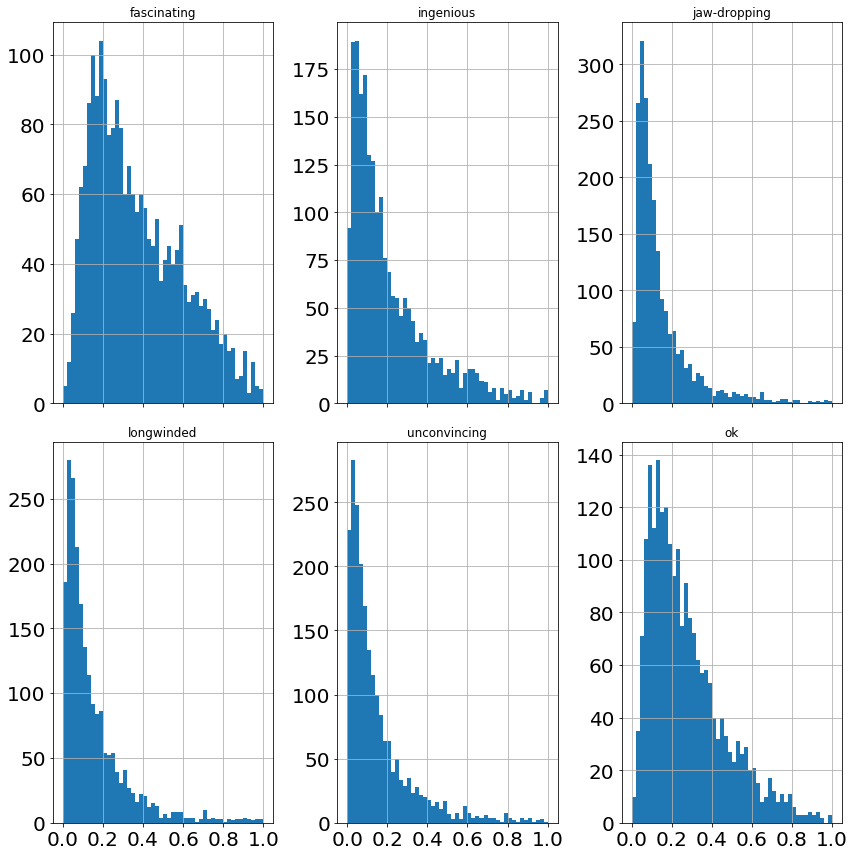

In [16]:
fig, axes = plt.subplots(2,3,figsize=(12,12),sharex=True)
for ind,rat in enumerate(rating_names):
    ax = axes[ind//3][ind%3]
    df.hist(column = rat, bins=50,ax=ax)
    ax.xaxis.set_major_locator(MultipleLocator(0.2))
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    
plt.tight_layout()
plt.savefig('../Plots/Figure7.pdf')

### 5e. Plot Figure 8(A,B)

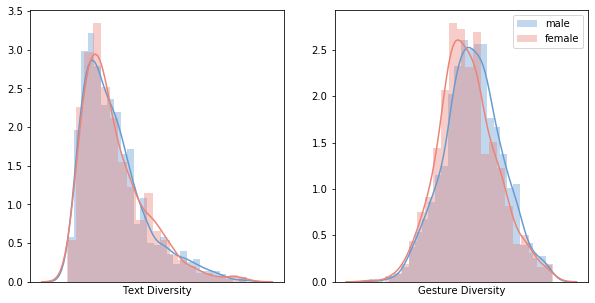

In [17]:
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol,figsize=(10,5))

sns.distplot(male_df["Text Diversity"],ax=axes[0],label='male',color='#669cd2')
sns.distplot(female_df["Text Diversity"],ax=axes[0],label='female',color='#ea8479')
#axes[0].legend()
axes[0].set_xticks([])
#axes[0].set_xlabel(False)

sns.distplot(male_df["Gesture Diversity"],ax=axes[1],label='male',color='#669cd2')
sns.distplot(female_df["Gesture Diversity"],ax=axes[1],label='female',color='#ea8479')
#axes[1].legend()
axes[1].set_xticks([])
#axes[1].set_xlabel(False)

plt.legend()
plt.savefig('../Plots/Figure8AB.pdf')

### 5f. Plot Figure 8(C,D)

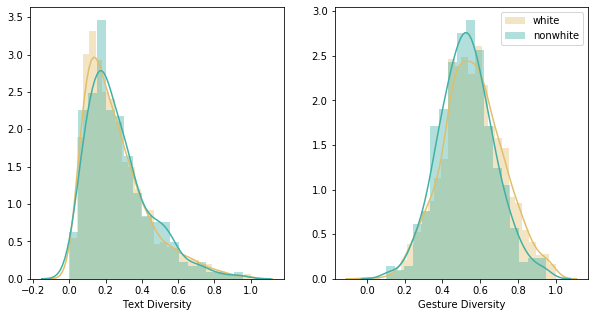

In [18]:
nrow=1
ncol=2
fig, axes = plt.subplots(nrow, ncol,figsize=(10,5))


sns.distplot(white_df["Text Diversity"],ax=axes[0],label='white',color='#E1BE6A')
sns.distplot(nonwhite_df["Text Diversity"],ax=axes[0],label='nonwhite',color='#40B0A6')
#axes[0].legend()


sns.distplot(white_df["Gesture Diversity"],ax=axes[1],label='white',color='#E1BE6A')
sns.distplot(nonwhite_df["Gesture Diversity"],ax=axes[1],label='nonwhite',color='#40B0A6')
plt.legend()

plt.savefig('../Plots/Figure8CD.pdf')

### 5g. Plot Figure 10

/Users/rupamacharyya/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:412: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


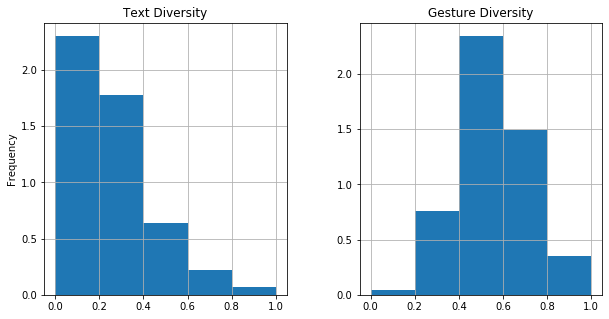

In [19]:
fig, axes = plt.subplots(1, 2,figsize=(10,5))
df.hist(column = "Text Diversity", bins=5,ax=axes[0],normed=True)
df.hist(column = "Gesture Diversity", bins=5,ax=axes[1],normed=True)
axes[0].set_ylabel("Frequency")
plt.savefig('../Plots/Figure10.pdf')

## 6. Plot Result Figures

### 6a. Plot Figure 6A

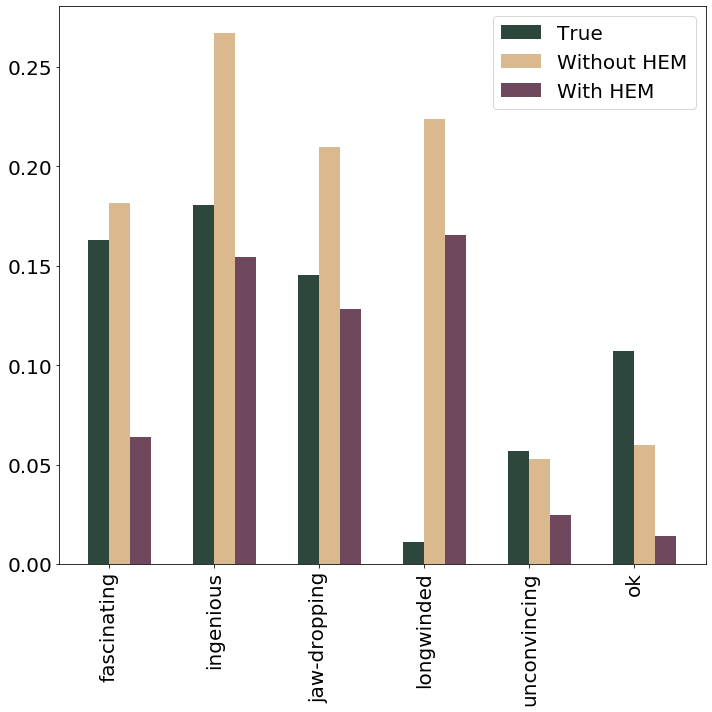

In [20]:
data_frame_predict_with_both, data_frame_true = load_pickle('../Output/For_plots/test_output_transcript_plus_video_True_True_7_0.017_5.0.pkl')
data_frame_predict, _ = load_pickle("../Output/For_plots/test_output_transcript_plus_video_False_False_7_0.3_0.3.pkl")


data_frame_predict = convert_dict_to_categorical_sub(data_frame_predict)
data_frame_true = convert_dict_to_categorical_sub(data_frame_true)
data_frame_predict_with_both = convert_dict_to_categorical_sub(data_frame_predict_with_both)




spd_pred_both,di_pred_both,spd_pred,di_pred,spd_true,di_true = fairness_list_gender(data_frame_predict_with_both,data_frame_predict, data_frame_true,rating_names)
rat_ind = [rating_names.index(x) for x in rating_names]
spd_pred,pd_pred_both,spd_true= [spd_pred[x] for x in rat_ind], [spd_pred_both[x] for x in rat_ind], [spd_true[x] for x in rat_ind]

xaxis = np.arange(len(rating_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(xaxis,spd_true  , width,label= 'True', color='#2E473C')
rects2 = ax.bar(xaxis + width, spd_pred, width, label= 'Without HEM', color='#D9B98D')    
rects3 = ax.bar(xaxis + width+ width, spd_pred_both , width, label= 'With HEM',color='#6F485E')
# rects4 = ax.bar(xaxis + width+width+width, pred, width, label='Without HEM',color='#6F485E')

ax.set_xticks(xaxis+width/2)
ax.set_xticklabels(rating_names,fontsize=20,rotation=90)

plt.legend(fontsize=20)

plt.yticks(fontsize=20)
plt.tight_layout() 
plt.savefig('../Plots/Figure6A.pdf')


### 6b. Plot Figure 6B

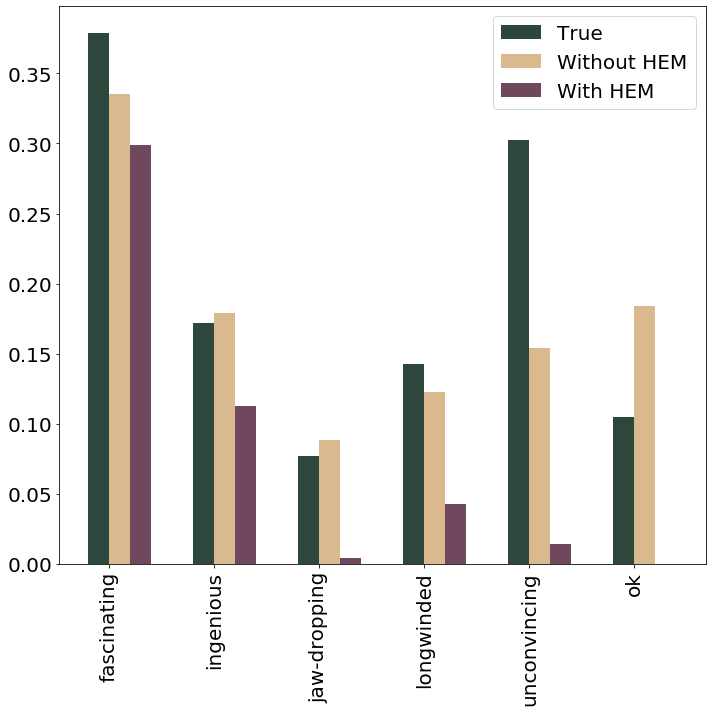

In [21]:
data_frame_predict_with_both, data_frame_true = load_pickle('../Output/For_plots/test_output_transcript_plus_video_True_True_7_0.02_4.0.pkl')
data_frame_predict, _ = load_pickle("../Output/For_plots/test_output_transcript_plus_video_False_False_7_0.3_0.3.pkl")


data_frame_predict = convert_dict_to_categorical_sub(data_frame_predict)
data_frame_true = convert_dict_to_categorical_sub(data_frame_true)
data_frame_predict_with_both = convert_dict_to_categorical_sub(data_frame_predict_with_both)




spd_pred_both,di_pred_both,spd_pred,di_pred,spd_true,di_true = fairness_list_race(data_frame_predict_with_both,data_frame_predict, data_frame_true,rating_names)
rat_ind = [rating_names.index(x) for x in rating_names]
spd_pred,pd_pred_both,spd_true= [spd_pred[x] for x in rat_ind], [spd_pred_both[x] for x in rat_ind], [spd_true[x] for x in rat_ind]

xaxis = np.arange(len(rating_names))
width = 0.2

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(xaxis,spd_true  , width,label= 'True', color='#2E473C')
rects2 = ax.bar(xaxis + width, spd_pred, width, label= 'Without HEM', color='#D9B98D')    
rects3 = ax.bar(xaxis + width+ width, spd_pred_both , width, label= 'With HEM',color='#6F485E')
# rects4 = ax.bar(xaxis + width+width+width, pred, width, label='Without HEM',color='#6F485E')

ax.set_xticks(xaxis+width/2)
ax.set_xticklabels(rating_names,fontsize=20,rotation=90)

plt.legend(fontsize=20)

plt.yticks(fontsize=20)
plt.tight_layout() 
plt.savefig('../Plots/Figure6B.pdf')


### 6c. Plot Figure 6C

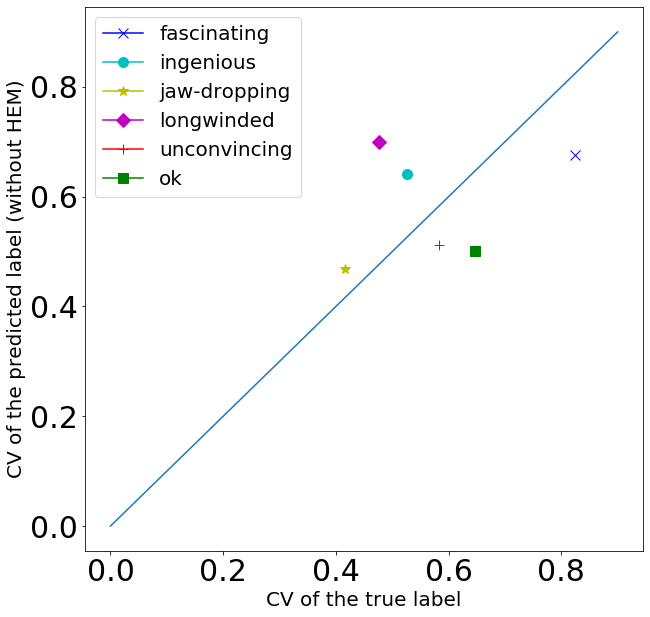

In [22]:
data_frame_predict_with_both, data_frame_true = load_pickle('../Output/For_plots/test_output_transcript_plus_video_True_True_7_0.02_4.0.pkl')
data_frame_predict, _ = load_pickle("../Output/For_plots/test_output_transcript_plus_video_False_False_7_0.3_0.3.pkl")

data_frame_predict = convert_dict_to_categorical_sub(data_frame_predict)
data_frame_true = convert_dict_to_categorical_sub(data_frame_true)
data_frame_predict_with_both = convert_dict_to_categorical_sub(data_frame_predict_with_both)

#Plot the predicted labels when HEM is NOT used
pred_std, truth_std, pred_mean, truth_mean, pred_prob_mat,truth_prob_mat = find_std_dev_sub(data_frame_predict, data_frame_true)
    

pred_mean = pred_mean + 0.00001
truth_mean = truth_mean + 0.00001
pred_cv = pred_std / pred_mean
truth_cv = truth_std / truth_mean

# print(pred_cv, truth_cv)
fig, ax = plt.subplots(figsize=(10,10))
marker_list = ['x','o','*','D','+','s']
colors = ['b', 'c', 'y', 'm', 'r','g']
for i in range(len(pred_cv)):
    plt.plot([truth_cv[i]],[pred_cv[i]],c=colors[i],marker= marker_list[i],label=rating_names[i],markersize=10)

#plt.scatter(truth_cv,pred_cv)
min_range = min(min(pred_std),min(truth_std))
max_range = max(max(pred_std),max(truth_std))
#line =np.linspace(min_range,max_range,100)
line =np.linspace(0,0.9,100)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)

plt.ylabel('CV of the predicted label (without HEM)',fontsize=20)
plt.xlabel('CV of the true label',fontsize=20)
plt.plot(line,line)
plt.legend(fontsize=20)
#plt.subplot(2,2,3)

plt.savefig('../Plots/Figure6C.pdf')

### 6d. Plot Figure 6D

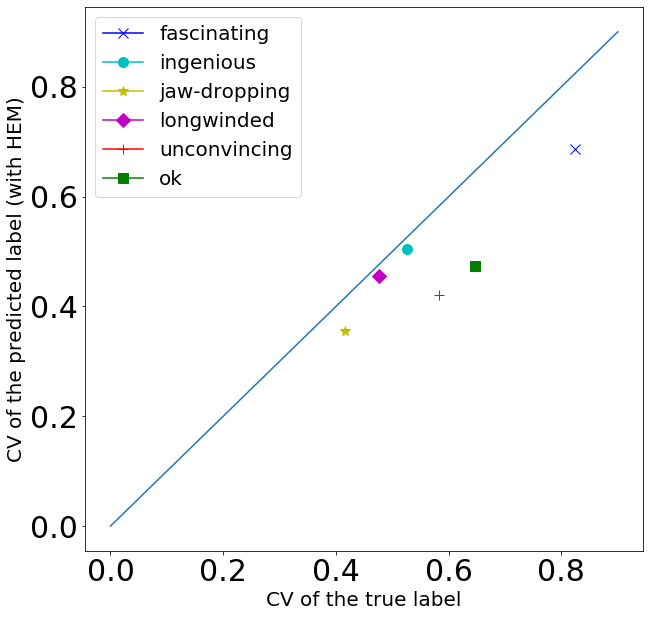

In [23]:
data_frame_predict_with_both, data_frame_true = load_pickle('../Output/For_plots/test_output_transcript_plus_video_True_True_7_0.02_4.0.pkl')
data_frame_predict, _ = load_pickle("../Output/For_plots/test_output_transcript_plus_video_False_False_7_0.3_0.3.pkl")

data_frame_predict = convert_dict_to_categorical_sub(data_frame_predict)
data_frame_true = convert_dict_to_categorical_sub(data_frame_true)
data_frame_predict_with_both = convert_dict_to_categorical_sub(data_frame_predict_with_both)


#Plot the predicted labels when HEM is used
pred_std, truth_std, pred_mean, truth_mean, pred_prob_mat,truth_prob_mat = find_std_dev_sub(data_frame_predict_with_both, data_frame_true)
    

pred_mean = pred_mean + 0.00001
truth_mean = truth_mean + 0.00001
pred_cv = pred_std / pred_mean
truth_cv = truth_std / truth_mean

# print(pred_cv, truth_cv)
fig, ax = plt.subplots(figsize=(10,10))
marker_list = ['x','o','*','D','+','s']
colors = ['b', 'c', 'y', 'm', 'r','g']
for i in range(len(pred_cv)):
    plt.plot([truth_cv[i]],[pred_cv[i]],c=colors[i],marker= marker_list[i],label=rating_names[i],markersize=10)

#plt.scatter(truth_cv,pred_cv)
min_range = min(min(pred_std),min(truth_std))
max_range = max(max(pred_std),max(truth_std))
#line =np.linspace(min_range,max_range,100)
line =np.linspace(0,0.9,100)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(30)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(30)


plt.ylabel('CV of the predicted label (with HEM)',fontsize=20)
plt.xlabel('CV of the true label',fontsize=20)
plt.plot(line,line)
plt.legend(fontsize=20)
#plt.subplot(2,2,3)

plt.savefig('../Plots/Figure6C.pdf')

## 7. Generate Table 1

In [24]:
data_frame_predict_with_both_1, data_frame_true = load_pickle('../Output/For_plots/test_output_transcript_plus_video_True_True_7_0.017_5.0.pkl')
data_frame_predict_with_both_2, data_frame_true = load_pickle('../Output/For_plots/test_output_transcript_plus_video_True_True_7_0.02_4.0.pkl')
data_frame_predict, _ = load_pickle("../Output/For_plots/test_output_transcript_plus_video_False_False_7_0.3_0.3.pkl")

acc_true = np.ones(6)
acc_pred = np.sum(data_frame_predict['rating']==data_frame_true['rating'],axis=0)/float(data_frame_predict['rating'].shape[0])
acc_pred_both_1 = np.sum(data_frame_predict_with_both_1['rating']==data_frame_true['rating'],axis=0)/float(data_frame_predict['rating'].shape[0])
acc_pred_both_2 = np.sum(data_frame_predict_with_both_2['rating']==data_frame_true['rating'],axis=0)/float(data_frame_predict['rating'].shape[0])

acc_list = [acc_true, acc_pred, acc_pred_both_1, acc_pred_both_2]


data_frame_predict = convert_dict_to_categorical_sub(data_frame_predict)
data_frame_true = convert_dict_to_categorical_sub(data_frame_true)
data_frame_predict_with_both_1 = convert_dict_to_categorical_sub(data_frame_predict_with_both_1)
data_frame_predict_with_both_2 = convert_dict_to_categorical_sub(data_frame_predict_with_both_2)

gender_spd_pred_both_1,_,gender_spd_pred,_,gender_spd_true,_ = fairness_list_gender(data_frame_predict_with_both_1,data_frame_predict, data_frame_true,rating_names)
gender_spd_pred_both_2,_,_,_,_,_ = fairness_list_gender(data_frame_predict_with_both_1,data_frame_predict, data_frame_true,rating_names)

race_spd_pred_both_1,_,race_spd_pred,_,race_spd_true,_ = fairness_list_race(data_frame_predict_with_both_1,data_frame_predict, data_frame_true,rating_names)
race_spd_pred_both_2,_,_,_,_,_ = fairness_list_gender(data_frame_predict_with_both_1,data_frame_predict, data_frame_true,rating_names)

gender_spd_list = [gender_spd_true,gender_spd_pred,gender_spd_pred_both_1,gender_spd_pred_both_2]
race_spd_list = [race_spd_true,race_spd_pred,race_spd_pred_both_1,race_spd_pred_both_2]


keys = ['Rating Names', 'Data_type', 'Accuracy', 'SPD(Gender)', 'SPD(Race)']
datatype_list = ['True','ep=0,lam=0','ep=0.017,lam=5','ep=0.02,lam=4']
dic = {}
for k in keys:
    dic[k] = []
    
for rat_ind, rating in enumerate(rating_names):
    for dind,dtype in enumerate(datatype_list):
        dic['Rating Names'].append(rating)
        dic['Data_type'].append(dtype)
        dic['Accuracy'].append(acc_list[dind][rat_ind])
        dic['SPD(Gender)'].append(gender_spd_list[dind][rat_ind])
        dic['SPD(Race)'].append(race_spd_list[dind][rat_ind])

result_df = pd.DataFrame(dic)
grouped_df = result_df.groupby('Data_type')
for key, item in grouped_df:
    print(grouped_df.get_group(key), "\n\n")


    Rating Names Data_type  Accuracy  SPD(Gender)  SPD(Race)
0    fascinating      True       1.0     0.163140   0.378713
4      ingenious      True       1.0     0.180305   0.171617
8   jaw-dropping      True       1.0     0.145305   0.077008
12    longwinded      True       1.0     0.011395   0.142464
16  unconvincing      True       1.0     0.056741   0.302530
20            ok      True       1.0     0.107012   0.104785 


    Rating Names   Data_type  Accuracy  SPD(Gender)  SPD(Race)
1    fascinating  ep=0,lam=0  0.770202     0.181471   0.334983
5      ingenious  ep=0,lam=0  0.750000     0.266976   0.179043
9   jaw-dropping  ep=0,lam=0  0.696970     0.209448   0.088834
13    longwinded  ep=0,lam=0  0.608586     0.223524   0.122662
17  unconvincing  ep=0,lam=0  0.611111     0.052981   0.154290
21            ok  ep=0,lam=0  0.611111     0.059801   0.183993 


    Rating Names       Data_type  Accuracy  SPD(Gender)  SPD(Race)
2    fascinating  ep=0.017,lam=5  0.747475     0.063997   0